<a href="https://colab.research.google.com/github/Saeeeae/Pytorch-Studying/blob/master/Transfer_Learning_torch_py.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from __future__ import print_function, division
# python 3, 2의 version 차이로 인해 호환되지 않는 것 호환시키는 것
# python 2의 기능을 가져와 python 3에서 동일하게 사용하는 것
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from google.colab import drive

drive.mount('/content/gdrive')

plt.ion() # interactive mode

# 실제로 충분한 크기의 데이터셋을 갖추기는 상대적으로 드물기 때문에, 
# (무작위 초기화를 통해) 바닥부터(from scratch) 전체 합성곱 신경망(Convolutional Network)를 
# 학습하는 사람은 거의 없습니다. 
# 대신, 매우 큰 데이터셋(예. 100가지 분류(Category)에 대해 
# 120만개의 이미지가 포함된 ImageNet)에서 합성곱 신경망(ConvNet)을 미리 학습(Pretrain)한 후,
# 이 합성곱 신경망을 관심있는 작업 (task of interest)을 위한 초기화(initialization)
# 또는 고정 특징 추출기(fixed feature extractor)로 사용합니다.

# 전이 학습 시나리오 2가지
# 1. 합성곱 신경망의 미세조정(Finetuning): 신경망을 imageNet 1000 데이터셋 등으로
#    미리 학습한 신경망으로 초기화
# 2. 고정 특정 추출기로써의 합성곱 신경망: 마지막의 완전히 연결된(FC) 계층을 제외한 모든 
#    신경망의 가중치를 고정시킴

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# Data 불러오기 
# torchvision, torch.utils.data 패키지 사용

data_transforms = {
    'train': transforms.Compose([
      transforms.RandomResizedCrop(224),
      transforms.RandomHorizontalFlip(),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = "gdrive/My Drive/Colab Notebooks/hymenoptera_data"
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
print(image_datasets)

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=4) for x in ['train', 'val']}

datasets_size = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
print(use_gpu)

{'train': Dataset ImageFolder
    Number of datapoints: 244
    Root location: gdrive/My Drive/Colab Notebooks/hymenoptera_data/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           ), 'val': Dataset ImageFolder
    Number of datapoints: 153
    Root location: gdrive/My Drive/Colab Notebooks/hymenoptera_data/val
    StandardTransform
Transform: Compose(
               Resize(size=256, interpolation=PIL.Image.BILINEAR)
               CenterCrop(size=(224, 224))
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )}
True


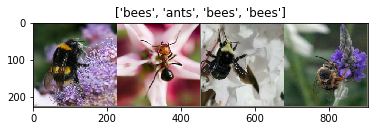

In [0]:
# 일부 이미지 시각화하기
def imshow(inp, title=None):
  """Imshow for Tensor."""
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.485, 0.465, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


In [0]:
# model train -> { Learning_Rate 관리(Scheduling), 최적의 모델 구하기}
# scheduler 매개변수는 torch.optim.lr_scheduler의 LR Scheduler 객체

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0

  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)

    for phase in ['train', 'val']:
      if phase == 'train':
        scheduler.step()
        model.train(True)
      else:
        model.train(False)
      
      running_loss = 0.0
      running_corrects = 0

      for data in dataloaders[phase]:
        inputs, labels = data
        
        if use_gpu:
          inputs = Variable(inputs.cuda())
          labels = Variable(labels.cuda())
        else:
          inputs, labels = Variable(inputs), Variable(labels)
        
        # zero the params gradients
        optimizer.zero_grad()

        # forward
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        # backward && optimize only if in training phase
        if phase == 'train':
          loss.backward()
          optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        

      epoch_loss = running_loss / datasets_size[phase]
      epoch_acc = running_corrects.double() / datasets_size[phase]

      print(' {} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

      if phase == 'val' and epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())

    print()

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [0]:
# 모델 예측값 시각화 하기

def visualize_model(model, num_images=6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()

  for i, data in enumerate(dataloaders['val']):
    inputs, labels = data
    if use_gpu:
      inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
    else:
      inputs, labels = Variable(inputs), Variable(labels)

    outputs = model(inputs)
    _, preds = torch.max(outputs.data, 1)

    for j in range(inputs.size()[0]):
      images_so_far +=1
      ax = plt.subplot(num_images//2, 2, images_so_far)
      ax.axis('off')
      ax.set_title('predicted: {}'.format(class_names[preds[j]]))
      imshow(inputs.cpu().data[j])

      if images_so_far == num_images:
        model.train(mode=was_training)
        return
  model.train(mode=was_training)

In [0]:
# 합성곱 신경망 미세조정(Finetuning)

model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
  model_ft = model_ft.cuda()

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

# train && test
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 260MB/s]


Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 train Loss: 0.5394 Acc: 0.7664
 val Loss: 0.2457 Acc: 0.8889

Epoch 1/24
----------
 train Loss: 0.9306 Acc: 0.7049
 val Loss: 0.4237 Acc: 0.8824

Epoch 2/24
----------
 train Loss: 0.5097 Acc: 0.8033
 val Loss: 0.3305 Acc: 0.8954

Epoch 3/24
----------
 train Loss: 0.3187 Acc: 0.8689
 val Loss: 0.4506 Acc: 0.8431

Epoch 4/24
----------
 train Loss: 0.4136 Acc: 0.8156
 val Loss: 0.2945 Acc: 0.9020

Epoch 5/24
----------
 train Loss: 0.4071 Acc: 0.8279
 val Loss: 0.3255 Acc: 0.8954

Epoch 6/24
----------
 train Loss: 0.3978 Acc: 0.8484
 val Loss: 0.3240 Acc: 0.9020

Epoch 7/24
----------
 train Loss: 0.3042 Acc: 0.8893
 val Loss: 0.3272 Acc: 0.9020

Epoch 8/24
----------
 train Loss: 0.3293 Acc: 0.8730
 val Loss: 0.2859 Acc: 0.9346

Epoch 9/24
----------
 train Loss: 0.3248 Acc: 0.8689
 val Loss: 0.2625 Acc: 0.9281

Epoch 10/24
----------
 train Loss: 0.2718 Acc: 0.8689
 val Loss: 0.3022 Acc: 0.9020

Epoch 11/24
----------
 train Loss: 0.3494 Acc: 0.8607
 val Loss: 0.2617 Acc: 0.9477



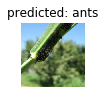

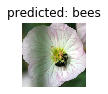

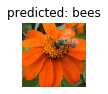

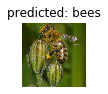

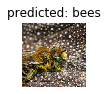

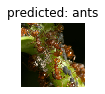

In [0]:
visualize_model(model_ft)

#고정 특정 추출기로써 합성곱 신경망 부터 다시해보기
#https://9bow.github.io/PyTorch-tutorials-kr-0.3.1/beginner/transfer_learning_tutorial.html

In [0]:
# 고정 특정 추출기로써의 합성곱 신경망
# 마지막 계츨을 제외한 모든 신경망을 고정(Freeze)
# requires_grad == False 설정해 매개변수 고정해서 backward()에서 gradient가 계산되지 않도록 함

model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
  param.requires_grad = False

# parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

if use_gpu:
  model_conv = model_conv.cuda()

criterion = nn.CrossEntropyLoss()

# only parameters of final layer are being optimized 
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [0]:
model_conv = train_model(model_conv, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:100: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule.See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


 train Loss: 0.6652 Acc: 0.6721
 val Loss: 0.2305 Acc: 0.9281

Epoch 1/24
----------
 train Loss: 0.4697 Acc: 0.7746
 val Loss: 0.2023 Acc: 0.9281

Epoch 2/24
----------
 train Loss: 0.4376 Acc: 0.7951
 val Loss: 0.1777 Acc: 0.9412

Epoch 3/24
----------
 train Loss: 0.3912 Acc: 0.8402
 val Loss: 0.2262 Acc: 0.9216

Epoch 4/24
----------
 train Loss: 0.4121 Acc: 0.8115
 val Loss: 0.2147 Acc: 0.9346

Epoch 5/24
----------
 train Loss: 0.4558 Acc: 0.7992
 val Loss: 0.1814 Acc: 0.9346

Epoch 6/24
----------
 train Loss: 0.4409 Acc: 0.8033
 val Loss: 0.1725 Acc: 0.9477

Epoch 7/24
----------
 train Loss: 0.3677 Acc: 0.8361
 val Loss: 0.1555 Acc: 0.9346

Epoch 8/24
----------
 train Loss: 0.2849 Acc: 0.8852
 val Loss: 0.1646 Acc: 0.9542

Epoch 9/24
----------
 train Loss: 0.3190 Acc: 0.8443
 val Loss: 0.1837 Acc: 0.9412

Epoch 10/24
----------
 train Loss: 0.4238 Acc: 0.8238
 val Loss: 0.1869 Acc: 0.9216

Epoch 11/24
----------
 train Loss: 0.3329 Acc: 0.8402
 val Loss: 0.2008 Acc: 0.9412



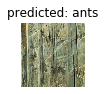

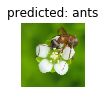

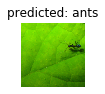

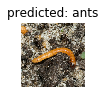

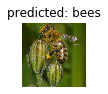

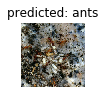

In [0]:
visualize_model(model_conv)

plt.ioff()
plt.show()